In [95]:
from robust_motor.datasets.motor_dynamics import _load_exp_data
from robust_motor.utils.helpers import get_model


from advertorch.attacks import GradientSignAttack, L2PGDAttack

import torch 
import torch.nn as nn
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
quants, index_quant_map = _load_exp_data('../data/Data_27012021_noisy/val/00000.mat')

In [10]:
inp_quants = ['voltage_d', 'voltage_q', 'speed']
out_quants = ['current_d', 'current_q', 'torque']

inp_quant_ids = [index_quant_map[x] for x in inp_quants]
out_quant_ids = [index_quant_map[x] for x in out_quants]

In [11]:
inp_seq = quants[inp_quant_ids, :]
out_seq = quants[out_quant_ids, :]

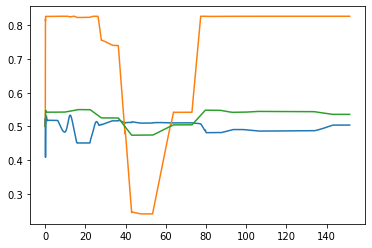

In [21]:
plt.plot(quants[10, :], inp_seq[0, :])
plt.plot(quants[10, :], inp_seq[1, :])
plt.plot(quants[10, :], inp_seq[2, :])

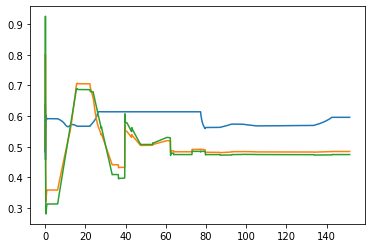

In [22]:
plt.plot(quants[10, :], out_seq[0, :])
plt.plot(quants[10, :], out_seq[1, :])
plt.plot(quants[10, :], out_seq[2, :])

In [29]:
class Namespace():
    def __init__(self):
        self.model = 'encdec_diag_birnn_skip'
        self.dataset = 'MotorDynamics'
        self.gpu = 0

args = Namespace()

In [30]:
model = get_model(args)
weight = torch.load('../weights/MotorDynamics/encdec_diag_birnn_skip/checkpoint-017.pt', map_location=torch.device(0))
model.load_state_dict(weight)

Parameters : 620387


<All keys matched successfully>

In [38]:
pred_seq = model(torch.tensor(inp_seq[:, :]).unsqueeze(0).cuda())

In [40]:
pred_seq = pred_seq.data.cpu().numpy()

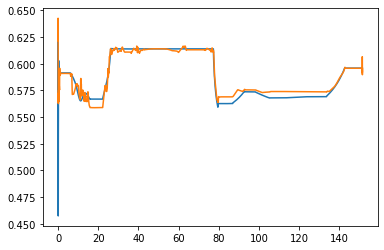

In [46]:
plt.plot(quants[10, :], out_seq[0, :])
plt.plot(quants[10, :], pred_seq[0, 0, :])
# plt.plot(quants[10, :], pred_seq[0, 1, :])
# plt.plot(quants[10, :], pred_seq[0, 2, :])

In [48]:
fgm_attack = GradientSignAttack(model, loss_fn=nn.MSELoss(), eps=0.01)

In [49]:
fgm_adv = fgm_attack.perturb(torch.tensor(inp_seq[:, :]).unsqueeze(0).cuda(), torch.tensor(out_seq[:, :]).unsqueeze(0).cuda())

In [52]:
pred_adv = model(fgm_adv)

In [53]:
pred_adv = pred_adv.squeeze().data.cpu().numpy()

In [54]:
fgm_adv = fgm_adv.squeeze().data.cpu().numpy()

In [90]:
st = 0 #50 * 250
et = -1 #70  *250

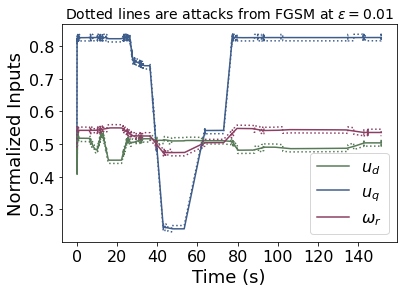

In [133]:
plt.plot(quants[10, st:et], inp_seq[0, st:et], color='#587A58', label=r'$u_d$')
plt.plot(quants[10, st:et], inp_seq[1, st:et], color='#3F5D8A', label=r'$u_q$')
plt.plot(quants[10, st:et], inp_seq[2, st:et], color='#8A3F63', label=r'$\omega_r$')

plt.plot(quants[10, st:et], fgm_adv[0, st:et], color='#587A58', linestyle=':')#, label=r'adv $u_d$')
plt.plot(quants[10, st:et], fgm_adv[1, st:et], color='#3F5D8A', linestyle=':')#, label=r'adv $u_q$')
plt.plot(quants[10, st:et], fgm_adv[2, st:et], color='#8A3F63', linestyle=':')#, label=r'adv $\omega_r$')
plt.ylabel('Normalized Inputs', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.title(r"Dotted lines are attacks from FGSM at $\epsilon=0.01$", fontsize=14)
plt.savefig('inp.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

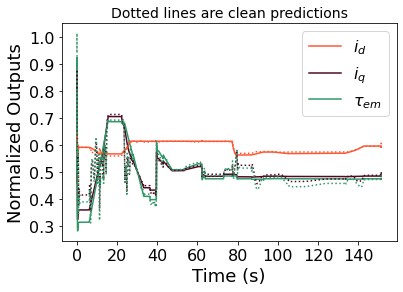

In [131]:
plt.plot(quants[10, st:et], out_seq[0, st:et], color='#FF5733', label=r'$i_d$')
plt.plot(quants[10, st:et], out_seq[1, st:et], color='#4F0925', label=r'$i_q$')
plt.plot(quants[10, st:et], out_seq[2, st:et], color='#329767', label=r'$\tau_{em}$')

plt.plot(quants[10, st:et], pred_seq[0, 0, st:et], color='#FF5733', linestyle=':')#, label='pred id')
plt.plot(quants[10, st:et], pred_seq[0, 1, st:et], color='#4F0925', linestyle=':')#, label='pred iq')
plt.plot(quants[10, st:et], pred_seq[0, 2, st:et], color='#329767', linestyle=':')#, label='pred torque')
plt.legend()
plt.ylabel('Normalized Outputs', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.title("Dotted lines are clean predictions", fontsize=14)
plt.savefig('clean.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

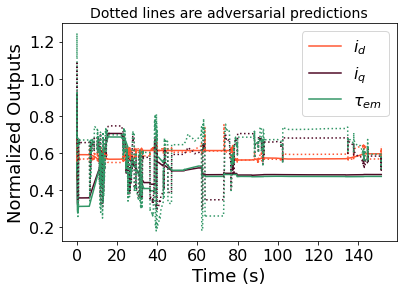

In [126]:
plt.plot(quants[10, st:et], out_seq[0, st:et], color='#FF5733', label=r'$i_d$')
plt.plot(quants[10, st:et], out_seq[1, st:et], color='#4F0925', label=r'$i_q$')
plt.plot(quants[10, st:et], out_seq[2, st:et], color='#329767', label=r'$\tau_{em}$')

plt.plot(quants[10, st:et], pred_adv[0, st:et], color='#FF5733', linestyle=':')#, label='adv id')
plt.plot(quants[10, st:et], pred_adv[1, st:et], color='#4F0925', linestyle=':')#, label='adv iq')
plt.plot(quants[10, st:et], pred_adv[2, st:et], color='#329767', linestyle=':')#, label='adv torque')
plt.ylabel('Normalized Outputs', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.title("Dotted lines are adversarial predictions", fontsize=14)
plt.savefig('adv.pdf', transparent=True, bbox_inches='tight', pad_inches=0)